# Titanic with all features + PCA

## Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

## Importing the dataset

In [ ]:
# Load Titanic data
df = pd.read_csv('/content/train.csv')

# Drop rows where 'Embarked' is missing (only 2 rows)
df = df.dropna(subset=['Embarked'])


##Model to predict the missing data for age (+20% of the rows) depending of the other variables

In [ ]:
# Features to help predict Age
features_for_age = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Create a temporary DataFrame with one-hot encoding
df_temp = pd.get_dummies(df[features_for_age + ['Age']], drop_first=True)

# Split into known and missing Age
df_age_known = df_temp[df_temp['Age'].notnull()]
df_age_missing = df_temp[df_temp['Age'].isnull()]

# Train the model
X_age = df_age_known.drop('Age', axis=1)
y_age = df_age_known['Age']

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_age, y_age)

# Predict missing ages
X_missing_age = df_age_missing.drop('Age', axis=1)
predicted_ages = rfr.predict(X_missing_age)

# Fill back into the original DataFrame
df.loc[df['Age'].isnull(), 'Age'] = predicted_ages

##New feature "Title" with the "Name"




In [ ]:
# Extract title
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                   'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                   'Jonkheer', 'Dona'], 'Rare')

df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# print(df['Title'].value_counts())


##New feature "FamilySize" and "IsAlone"


In [ ]:
# Create FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create IsAlone
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# print(df[['SibSp', 'Parch', 'FamilySize', 'IsAlone']].head())


## New features: "FareBin" and "AgeBin"

In [ ]:
# AgeBand: split into 5 roughly equal-sized bins
df['AgeBand'] = pd.cut(df['Age'], 5)

# Create AgeBin (numeric version for modeling)
df['AgeBin'] = pd.cut(df['Age'], 5, labels=[0, 1, 2, 3, 4]).astype(int)

# FareBand: split into 4 quantile-based bins
df['FareBand'] = pd.qcut(df['Fare'], 4)

# Create FareBin (numeric version for modeling)
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)

# print(df[['Age', 'AgeBand', 'AgeBin', 'Fare', 'FareBand', 'FareBin']].head())


## Preprocessing pipeline

In [ ]:
# Define features and target
X = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', "IsAlone", "FamilySize", "FareBin", "AgeBin", "Age", "Fare"]] #"Cabin" has too many NA values to be used
y = df['Survived']

# Column groups
numeric_features = ['SibSp', 'Parch', "FamilySize", "Age", "Fare"]
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', "IsAlone", "FareBin", "AgeBin" ]

# Pipelines
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Apply transformations
preprocessor.fit(X)

# Get column names
num_cols = numeric_features
cat_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_columns = list(num_cols) + list(cat_cols)

# Wrap in DataFrame
X_final = pd.DataFrame(X_prepro, columns=all_columns)

# Optional: display the result
print(X_final.head())

      SibSp     Parch  FamilySize       Age      Fare  Pclass_1  Pclass_2  \
0  0.431350 -0.474326    0.057853 -0.545560 -0.500240       0.0       0.0   
1  0.431350 -0.474326    0.057853  0.619174  0.788947       1.0       0.0   
2 -0.475199 -0.474326   -0.561804 -0.254377 -0.486650       0.0       0.0   
3  0.431350 -0.474326    0.057853  0.400786  0.422861       1.0       0.0   
4 -0.475199 -0.474326   -0.561804  0.400786 -0.484133       0.0       0.0   

   Pclass_3  Sex_female  Sex_male  ...  IsAlone_1  FareBin_0  FareBin_1  \
0       1.0         0.0       1.0  ...        0.0        1.0        0.0   
1       0.0         1.0       0.0  ...        0.0        0.0        0.0   
2       1.0         1.0       0.0  ...        1.0        0.0        1.0   
3       0.0         1.0       0.0  ...        0.0        0.0        0.0   
4       1.0         0.0       1.0  ...        1.0        0.0        1.0   

   FareBin_2  FareBin_3  AgeBin_0  AgeBin_1  AgeBin_2  AgeBin_3  AgeBin_4  
0        0

##Import the models

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

##Define models and their hyperparameters

In [ ]:
model_params = {
    'SVC': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.05, 0.1]
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=500, random_state=42),
        'params': {
            'model__hidden_layer_sizes': [(100,), (50, 50)],
            'model__alpha': [0.0001, 0.001]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': [None, 5, 10],
            'model__criterion': ['gini', 'entropy']
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'Voting': {
        'model': VotingClassifier(
            estimators=[
                ('svc', SVC(probability=True, random_state=42)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
                ('mlp', MLPClassifier(max_iter=500, random_state=42))
            ],
            voting='soft'
        ),
        'params': {}  # No hyperparameters to tune here directly
    }
}

##Spliting the data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Loop on all the models to find the best parameters with a cross validation and PCA

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

best_models = {}

# New pipeline: preprocessing ➜ PCA ➜ model
for name, mp in model_params.items():
    pipe = Pipeline([
        ('preprocessing', preprocessor),        # Scaling + OneHotEncoding
        ('pca', PCA(n_components=0.95)),        # Keep 95% of variance
        ('model', mp['model'])                  # The actual classifier
    ])

    clf = GridSearchCV(pipe, mp['params'], cv=5, n_jobs=-1, scoring='accuracy')
    clf.fit(X_train, y_train)  # X is still your original DataFrame with column names

    print(f"Best parameters for {name}: {clf.best_params_}")
    print(f"Validation Accuracy for {name}: {clf.best_score_:.4f}")

    best_models[name] = clf.best_estimator_

pca = model.named_steps['pca']
print(f"{name} - PCA n_components: {pca.n_components_}")


Best parameters for SVC: {'model__C': 10, 'model__kernel': 'rbf'}
Validation Accuracy for SVC: 0.8396
Best parameters for RandomForest: {'model__max_depth': 10, 'model__n_estimators': 200}
Validation Accuracy for RandomForest: 0.8200
Best parameters for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Validation Accuracy for XGBoost: 0.8255
Best parameters for MLP: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100,)}
Validation Accuracy for MLP: 0.8369
Best parameters for KNN: {'model__n_neighbors': 7, 'model__weights': 'uniform'}
Validation Accuracy for KNN: 0.8228
Best parameters for DecisionTree: {'model__criterion': 'gini', 'model__max_depth': 5}
Validation Accuracy for DecisionTree: 0.8101
Best parameters for ExtraTrees: {'model__max_depth': 10, 'model__n_estimators': 100}
Validation Accuracy for ExtraTrees: 0.8228
Best parameters for GradientBoosting: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 100

## Display accuracy with the best parameters for each model

In [ ]:
from sklearn.metrics import accuracy_score

# Optionally test on hold-out set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for {name}: {acc:.4f}")

Test accuracy for SVC: 0.7921
Test accuracy for RandomForest: 0.7697
Test accuracy for XGBoost: 0.7753
Test accuracy for MLP: 0.8146
Test accuracy for KNN: 0.7921
Test accuracy for DecisionTree: 0.7978
Test accuracy for ExtraTrees: 0.7697
Test accuracy for GradientBoosting: 0.7640
Test accuracy for Voting: 0.7978


# 🧠 Titanic Classification – Feature Selection & PCA Analysis

---

## ✅ 1. Feature Evaluation Summary

The features `FareBin` and `AgeBin` are derived from `Fare` and `Age`, so they are naturally correlated.  
To evaluate their impact, I tested three feature configurations:

- 🔹 **Version 1 – Baseline**: Without `Fare`, `Age`, `FareBin`, and `AgeBin`
- 🔹 **Version 2 – Binned Only**: All features included **except** `Fare` and `Age`
- 🔹 **Version 3 – All Features**: Including both original and binned versions of `Fare` and `Age`

---

## 📊 2. Accuracy Comparison (No PCA)

### 🔹 Version 1 – No Fare / Age / Binned

| Model              | Test Accuracy |
|-------------------|----------------|
| SVC               | 0.7921         |
| RandomForest      | 0.7978         |
| XGBoost           | 0.7921         |
| MLP               | 0.8034         |
| KNN               | 0.7640         |
| DecisionTree      | 0.7865         |
| ExtraTrees        | 0.7978         |
| GradientBoosting  | 0.7978         |
| **VotingClassifier** | **0.8202**     |

---

### 🔹 Version 2 – Binned Only (No Fare / Age)

- ✅ Best Accuracy: **XGBoost – 0.7921**

---

### 🔹 Version 3 – All Features (Original + Binned)

| Model              | Test Accuracy |
|-------------------|----------------|
| SVC               | 0.7865         |
| RandomForest      | 0.7697         |
| XGBoost           | 0.8034         |
| MLP               | 0.7753         |
| KNN               | 0.7978         |
| DecisionTree      | **0.8202**     |
| ExtraTrees        | 0.8034         |
| GradientBoosting  | **0.8202**     |
| VotingClassifier  | 0.8146         |

---

## ✅ 3. Final Feature Selection Decision

- 🔹 Best result **without Fare/Age/Binned**: `VotingClassifier – 0.8202`
- 🔹 Best result **with binned only**: `XGBoost – 0.7921`
- 🔹 Best result **with all features**: `GradientBoosting / DecisionTree – 0.8202`

➡️ **Decision**: Use **all features** (original + binned) for optimal performance and model flexibility.

---

## 🧪 4. PCA – Dimensionality Reduction

Test accuracy results after applying PCA:

| Model              | Test Accuracy |
|-------------------|----------------|
| SVC               | 0.7921         |
| RandomForest      | 0.7697         |
| XGBoost           | 0.7753         |
| MLP               | **0.8146**     |
| KNN               | 0.7921         |
| DecisionTree      | 0.7978         |
| ExtraTrees        | 0.7697         |
| GradientBoosting  | 0.7640         |
| VotingClassifier  | 0.7978         |

➡️ PCA yielded slightly lower accuracy in most models, except MLP which performed well (0.8146).

---

## 📌 5. Next Steps

- 📈 Visualize **feature importances** from the best baseline model
- 🎯 Plot **PCA components** (2D projection)
- 📊 Compare model performances visually (Titanic with new features)

---



## PLot the best features with PCA

🔍 Top contributing features to PC1:
FamilySize    0.545930
SibSp         0.477275
Parch         0.450009
Age           0.246953
IsAlone_1     0.211062
IsAlone_0     0.211062
Fare          0.202599
Title_Mr      0.129256
AgeBin_0      0.114096
FareBin_3     0.112883
Name: PC1, dtype: float64

🔍 Top contributing features to PC2:
Fare         0.606914
Age          0.564328
Pclass_3     0.271015
Pclass_1     0.268025
FareBin_3    0.204780
AgeBin_1     0.156943
AgeBin_2     0.136649
FareBin_0    0.118066
SibSp        0.106982
AgeBin_3     0.101602
Name: PC2, dtype: float64


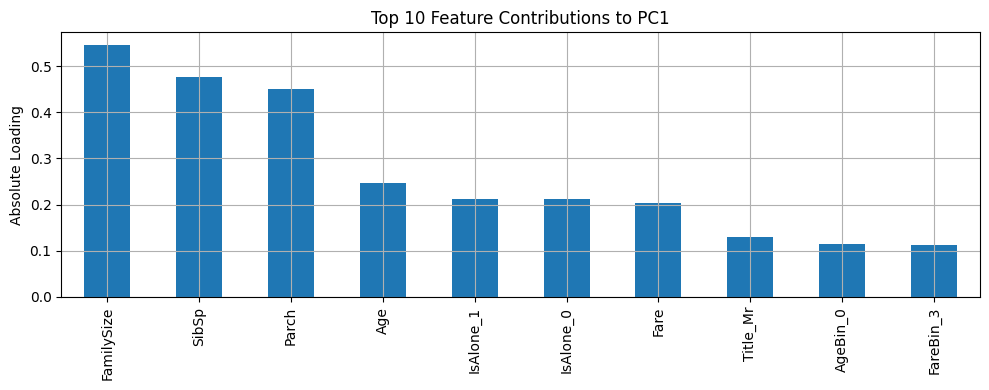

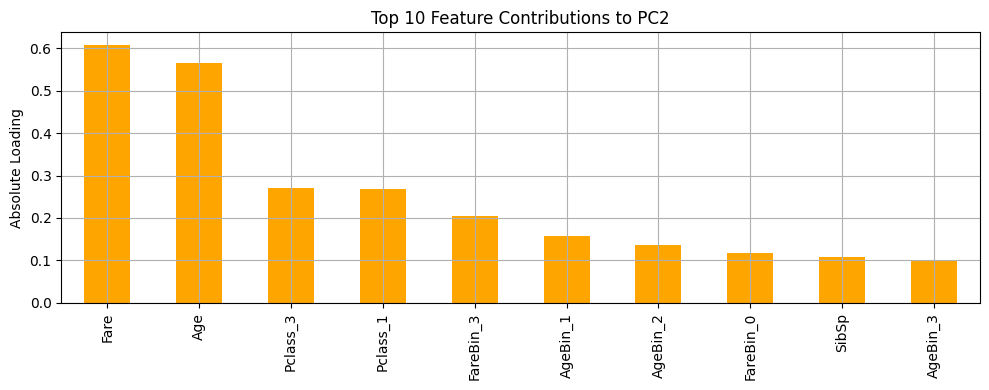

In [ ]:
import matplotlib.pyplot as plt

# Pick any fitted model using PCA (they all share the same PCA preprocessing)
fitted_pipeline = best_models['MLP']

# Extract fitted PCA step
pca = fitted_pipeline.named_steps['pca']

# Extract feature names from preprocessor
# Assumes you're using ColumnTransformer with OneHotEncoder and StandardScaler
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(preprocessor.transformers_[1][2])
all_features = np.concatenate([num_features, cat_features])

# Build a DataFrame with PCA components (loadings)
pca_components = pd.DataFrame(pca.components_, columns=all_features, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# Sort and display top contributors to PC1
top_pc1 = pca_components.loc['PC1'].abs().sort_values(ascending=False).head(10)
top_pc2 = pca_components.loc['PC2'].abs().sort_values(ascending=False).head(10)

print("🔍 Top contributing features to PC1:")
print(top_pc1)

print("\n🔍 Top contributing features to PC2:")
print(top_pc2)

# 📊 Barplot for PC1
plt.figure(figsize=(10, 4))
top_pc1.plot(kind='bar')
plt.title('Top 10 Feature Contributions to PC1')
plt.ylabel('Absolute Loading')
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Barplot for PC2
plt.figure(figsize=(10, 4))
top_pc2.plot(kind='bar', color='orange')
plt.title('Top 10 Feature Contributions to PC2')
plt.ylabel('Absolute Loading')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🧠 PCA Component Summary

After applying PCA, we examined the top contributing features to understand what each principal component captures.

- **PC1** mainly reflects **family-related structure**, with the strongest influence coming from `FamilySize`, followed by `SibSp`, `Parch`, and `Age`.

- **PC2** is driven by **socio-economic variables**, primarily `Fare` and `Age`, with additional influence from passenger class (`Pclass_1`, `Pclass_3`).

These insights confirm that PCA retains meaningful relationships in the data, making it a valuable step before modeling.